# Poisson Distribution with NGBoost

**Problem**: Count regression — predicting non-negative integer outcomes.

**When to use**:
- Event counts: number of customer arrivals, website visits, defects
- Epidemiology: number of disease cases per region
- Ecology: species counts per sampling area
- Any non-negative integer outcome where the variance ≈ the mean

**Parameters**: Single parameter `mu` (rate, log-transformed).
Mean = Variance = mu. If your data has overdispersion (variance >> mean),
consider `BetaBinomial` instead.

In [2]:
import numpy as np
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from ngboost import NGBRegressor
from ngboost.distns import Poisson

## 1. Generate synthetic count data

In [3]:
np.random.seed(42)
n_samples = 1500
X = np.random.randn(n_samples, 5)

# True rate depends on features (always positive via exp link)
true_mu = np.exp(1.5 + 0.8 * X[:, 0] - 0.5 * X[:, 1])
Y = np.random.poisson(true_mu).astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Y range: [{Y.min():.0f}, {Y.max():.0f}]")
print(f"Y mean: {Y.mean():.2f}, Y variance: {Y.var():.2f}")
print(f"Train: {len(Y_train)}, Test: {len(Y_test)}")

Y range: [0, 282]
Y mean: 7.32, Y variance: 125.80
Train: 1200, Test: 300


## 2. Train NGBoost

In [4]:
tree_learner = DecisionTreeRegressor(
    criterion="friedman_mse",
    min_samples_split=10,
    min_samples_leaf=3,
    max_depth=5,
    random_state=None,
)
ngb = NGBRegressor(
    Dist=Poisson,
    n_estimators=500,
    learning_rate=0.01,
    verbose=False,
    random_state=42,
    Base=tree_learner,
)
ngb.fit(X_train, Y_train)
print("Training complete.")

Training complete.


## 3. Predictions and parameters

In [5]:
dists = ngb.pred_dist(X_test)
Y_pred = ngb.predict(X_test)

print("Estimated rate mu (first 5 test samples):")
print(f"  mu: {dists.mu[:5].round(3)}")
print(f"\nPredicted mean (first 5): {Y_pred[:5].round(2)}")
print(f"Actual (first 5):          {Y_test[:5].astype(int)}")

Estimated rate mu (first 5 test samples):
  mu: [13.187  3.445  3.476  6.324  3.131]

Predicted mean (first 5): [13.19  3.44  3.48  6.32  3.13]
Actual (first 5):          [15  4  4 12  6]


## 4. Prediction intervals from PMF

In [6]:
# For a discrete distribution, use ppf for quantile-based intervals
q10 = dists.ppf(0.1)
q90 = dists.ppf(0.9)

coverage = np.mean((Y_test >= q10) & (Y_test <= q90))
print(f"80% prediction interval coverage: {coverage:.1%} (target: ~80%)")

80% prediction interval coverage: 84.0% (target: ~80%)


## 5. Visualize

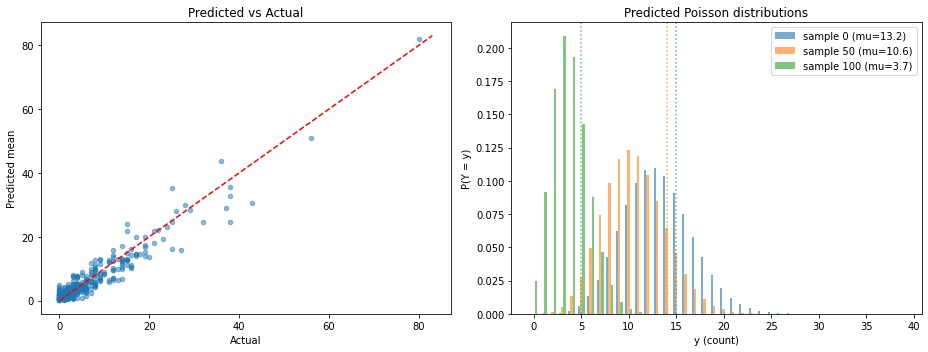

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax = axes[0]
ax.scatter(Y_test, Y_pred, alpha=0.5, s=20)
lims = [0, max(Y_test.max(), Y_pred.max()) + 1]
ax.plot(lims, lims, "r--")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted mean")
ax.set_title("Predicted vs Actual")

ax = axes[1]
for idx in [0, 50, 100]:
    mu_i = dists.mu[idx]
    k_max = int(mu_i * 3) + 1
    k = np.arange(0, k_max)
    pmf = scipy.stats.poisson.pmf(k, mu_i)
    offset = 0.25 * [0, 50, 100].index(idx) - 0.25
    ax.bar(k + offset, pmf, width=0.25, alpha=0.6,
           label=f"sample {idx} (mu={mu_i:.1f})")
    ax.axvline(Y_test[idx], color=f"C{[0, 50, 100].index(idx)}",
               linestyle=":", alpha=0.7)
ax.set_xlabel("y (count)")
ax.set_ylabel("P(Y = y)")
ax.set_title("Predicted Poisson distributions")
ax.legend()

plt.tight_layout()
plt.show()